In [51]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import InstanceHardnessThreshold
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [3]:
'''CONFIG FOR LOCAL / CLOUD RUNNING'''
running_local = 'content' not in os.getcwd()
if running_local:
    path = ''
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path = 'drive/MyDrive/StructuralBioinformatics/'

Mounted at /content/drive


In [8]:
dfs = []
for filename in os.listdir(path + 'data/features_ring'):
    if filename[-4:] == '.tsv':
        dfs.append(pd.read_csv(path + 'data/features_ring/' + filename, sep='\t'))
df = pd.concat(dfs)
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,6hqc,A,158,,G,E,0.190,16.0,14.0,2.718,...,23.0,-2.075,2.395,H,1.538,-0.055,1.502,0.440,2.897,NaN
1,6hqc,A,142,,I,E,0.533,9.0,8.0,-2.019,...,19.0,-2.173,2.344,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND
2,6hqc,A,141,,Q,E,0.525,7.0,12.0,-1.418,...,13.0,-0.895,-0.620,H,1.050,0.302,-3.656,-0.259,-3.242,VDW
3,6hqc,A,90,,T,E,0.521,10.0,12.0,-2.336,...,23.0,-2.075,2.395,H,1.538,-0.055,1.502,0.440,2.897,VDW
4,6hqc,A,93,,S,S,0.146,13.0,9.0,-1.529,...,16.0,-2.596,2.664,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,6fuc,A,192,,L,G,0.012,17.0,20.0,-0.918,...,15.0,-1.254,-0.575,H,-0.032,0.326,2.213,0.908,1.313,HBOND
734,6fuc,A,192,,L,G,0.012,17.0,20.0,-0.918,...,15.0,-1.254,-0.575,H,-0.032,0.326,2.213,0.908,1.313,VDW
735,6fuc,A,104,,R,H,0.468,9.0,21.0,-1.043,...,10.0,-1.289,-0.738,H,-0.595,0.009,0.672,-2.128,-0.184,VDW
736,6fuc,A,100,,A,H,0.434,10.0,14.0,-1.007,...,19.0,-1.126,-0.671,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND


In [30]:
df = df[df.Interaction.notna()]
contact_dict = {"HBOND": 0, "IONIC": 1, "PICATION": 2, "PIPISTACK": 3, "SSBOND": 4, "VDW": 5}
y = df['Interaction']
cat_names = list(y.astype('category').cat.categories)
y.replace(contact_dict, inplace=True)
X = df[['s_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)
X

,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5
1,9.0,8.0,-2.019,-0.059,-1.239,-0.547,2.131,0.393,0.816,8.0,19.0,-2.173,2.344,-1.019,-0.987,-1.505,1.266,-0.912
2,7.0,12.0,-1.418,2.219,0.931,-0.179,-3.005,-0.503,-1.853,2.0,13.0,-0.895,-0.620,1.050,0.302,-3.656,-0.259,-3.242
3,10.0,12.0,-2.336,2.279,-0.032,0.326,2.213,0.908,1.313,9.0,23.0,-2.075,2.395,1.538,-0.055,1.502,0.440,2.897
4,13.0,9.0,-1.529,2.821,-0.228,1.399,-4.760,0.670,-2.647,5.0,16.0,-2.596,2.664,-0.591,-1.302,-0.733,1.570,-0.146
6,19.0,21.0,-1.733,1.989,-1.019,-0.987,-1.505,1.266,-0.912,18.0,9.0,-1.574,-0.723,-1.239,-0.547,2.131,0.393,0.816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,17.0,20.0,-0.918,-0.626,-1.019,-0.987,-1.505,1.266,-0.912,16.0,15.0,-1.254,-0.575,-0.032,0.326,2.213,0.908,1.313
734,17.0,20.0,-0.918,-0.626,-1.019,-0.987,-1.505,1.266,-0.912,16.0,15.0,-1.254,-0.575,-0.032,0.326,2.213,0.908,1.313
735,9.0,21.0,-1.043,-0.689,1.538,-0.055,1.502,0.440,2.897,12.0,10.0,-1.289,-0.738,-0.595,0.009,0.672,-2.128,-0.184
736,10.0,14.0,-1.007,-0.674,-0.591,-1.302,-0.733,1.570,-0.146,20.0,19.0,-1.126,-0.671,-1.019,-0.987,-1.505,1.266,-0.912


In [31]:
feature_sel = SelectFromModel(LogisticRegression(max_iter=1000))
feature_sel.fit(X, y)
X = feature_sel.transform(X)
minMax = MinMaxScaler()
minMax.fit(X)
X_scaled = minMax.transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
input_dim = X_scaled.shape[1]
num_classes = len(cat_names)
num_classes

6

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=100)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [33]:
def balance(X, y, n_samples):
  under_classes = {}
  over_classes =  {}
  _, counts = np.unique(y, return_counts = True)
  for i in range(6):
    if n_samples[i] < counts[i]:
      under_classes[i] = n_samples[i]
    else:
      over_classes[i] = n_samples[i]
    print("Applying undersampeling")
    undersample = InstanceHardnessThreshold(estimator = AdaBoostClassifier(), sampling_strategy = under_classes)
    X_bal, y_bal = undersample.fit_resample(X, y)
    print("Applying SMOTE")
    oversample = SMOTE(sampling_strategy = over_classes)
    X_bal, y_bal = oversample.fit_resample(X, y)
    return X_bal, y_bal

In [34]:
# balancing is only applied to training data
X_bal, y_bal = balance(X_train, y_train, [64000,64000,64000,64000,64000,64000])

applying undersampeling
Applying SMOTE


In [52]:
y_cat = to_categorical(y_bal, num_classes)

In [38]:
def init():
  model = Sequential()
  model.add(Input(input_dim))
  model.add(Dense(units=64, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=128, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=256, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=256, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=256, activation='relu', kernel_initializer="glorot_normal"))
  model.add(Dense(units=num_classes, activation='softmax', kernel_initializer="glorot_normal"))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['AUC'])
  return model

In [45]:
mdl = init()
mdl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                448       
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 dense_16 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 174,918
Trainable params: 174,918
Non-tr

In [55]:
es = EarlyStopping(
                       monitor='loss',
                       mode='min',
                       patience=5,
                       min_delta=0.0001
                       )
fold = 0
hist = []
for train_idx, val_idx in kf.split(X_bal, y_bal):
  fold += 1
  print(f"Fold {fold}/10")
  Xfold_train, Xfold_val = X_bal[train_idx], X_bal[val_idx]
  yfold_cat_train, yfold_cat_val = y_cat[train_idx], y_cat[val_idx]
  metrics = mdl.fit(Xfold_train, yfold_cat_train,
          validation_data=(Xfold_val, yfold_cat_val),
          epochs=100, verbose=1,
          batch_size=16000,
          callbacks=[es])
  hist.append(metrics)


Fold 1/10
Epoch 1/100
27/27 [==============================] - 13s 468ms/step - loss: 0.6337 - auc: 0.9470 - val_loss: 0.6401 - val_auc: 0.9465
Epoch 2/100
27/27 [==============================] - 10s 382ms/step - loss: 0.6350 - auc: 0.9467 - val_loss: 0.6326 - val_auc: 0.9473
Epoch 3/100
27/27 [==============================] - 10s 362ms/step - loss: 0.6319 - auc: 0.9473 - val_loss: 0.6313 - val_auc: 0.9475
Epoch 4/100
27/27 [==============================] - 12s 432ms/step - loss: 0.6307 - auc: 0.9475 - val_loss: 0.6336 - val_auc: 0.9474
Epoch 5/100
27/27 [==============================] - 11s 420ms/step - loss: 0.6316 - auc: 0.9473 - val_loss: 0.6308 - val_auc: 0.9476
Epoch 6/100
27/27 [==============================] - 10s 362ms/step - loss: 0.6315 - auc: 0.9473 - val_loss: 0.6289 - val_auc: 0.9479
Epoch 7/100
27/27 [==============================] - 11s 388ms/step - loss: 0.6299 - auc: 0.9476 - val_loss: 0.6285 - val_auc: 0.9479
Epoch 8/100
27/27 [==============================] -

1610/1610 [==============================] - 7s 4ms/step
Accuracy:  0.6757202764619088


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


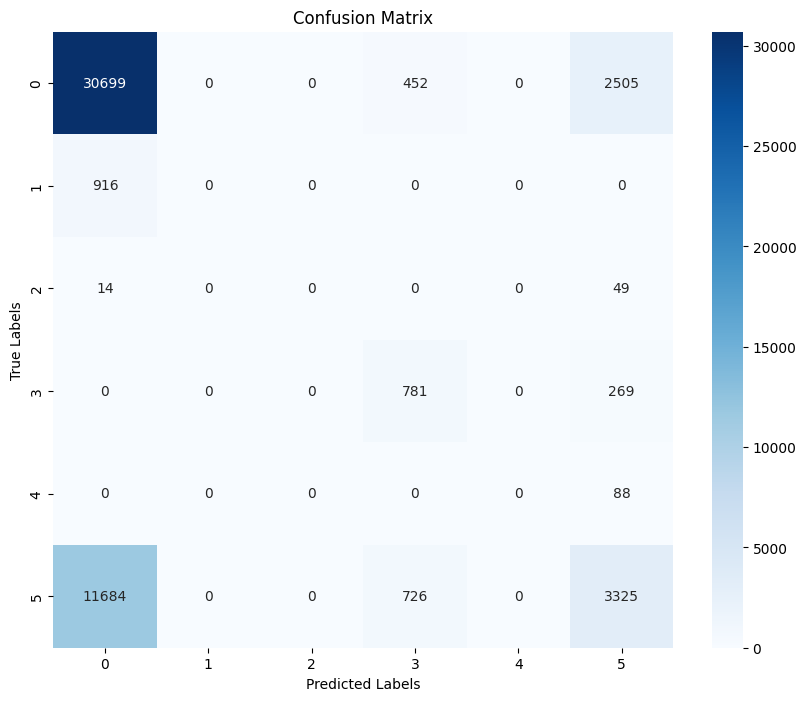

              precision    recall  f1-score   support

           0       0.71      0.91      0.80     33656
           1       0.00      0.00      0.00       916
           2       0.00      0.00      0.00        63
           3       0.40      0.74      0.52      1050
           4       0.00      0.00      0.00        88
           5       0.53      0.21      0.30     15735

    accuracy                           0.68     51508
   macro avg       0.27      0.31      0.27     51508
weighted avg       0.63      0.68      0.62     51508



In [57]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def report(model, X_test, y_test):
    outputs = model.predict(X_test)
    y_pred = np.argmax(outputs, axis=1)
    # y_true = np.argmax(y_test, axis=1)
    y_true = y_test

    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: ", accuracy)
    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Plotting confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return report

report = report(mdl, X_test, y_test)
print(report)
